# Chapter6. 합성곱 신경망 II

## 이미지 분류를 위한 신경망

### LeNet-5

LeNet-5는 합성곱 신경망이라는 개념을 최초로 얀 르쿤이 개발한 구조입니다.
LeNet-5는 합성곱과 다운 샘플링(혹은 풀링)을 반복적으로 거치면서 마지막에 완전연결층에서 분류를 수행합니다.

다음 이미지를 이용하여 구체적으로 살펴보면 C1에서 5x5 합성곱 연산 후 28x28 크기의 특성 맵 여섯 개를 생성합니다. S2에서 다운 샘플링하여 특성 맵 크기를 14x14로 줄입니다. 다시 C3에서 5x5 합성곱 연산하여 10x10 크기의 특성 맵 16개를 생성하고, S4에서 다운 샘플링하여 특성 맵 크기를 5x5로 줄입니다. C5에서 5x5 합성곱 연산하여 1x1 크기의 특성 맵 120개를 생성하고, 마지막으로 F6에서 완전연결층으로 C5의 결과 유닛(또는 노드) 84개에 연결시킵니다. 이때 C로 시작하는 것은 합성곱층을 의미하고, S로 시작하는 것은 풀링층을 의미합니다. 또한 F로 시작하는 것은 완전연결층을 의미합니다.

In [ ]:
pip install --user tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # 이미지 변환(전처리) 기능을 제공하는 라이브러리
from torch.autograd import Variable
from torch import optim # 경사 하강법을 이용하여 가중치를 구하기 위한 옵티마이저 라이브러리
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm # 진행 상황을 가식적으로 표현해 주는데, 특히 모델의 학습 경과를 확인하고 싶을 때 사용하는 라이브러리
import random
from matplotlib import pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 파이토치는 텐서플로와 다르게 GPU를 자동으로 할당해 주지 않기 때문에 GPU 할당을 모델과 데이터에 선언해 주어야 합니다. 단 이장에서는 CPU를 사용합니다.

In [ ]:
class ImageTransform():
    def __init__(self, resize, mean, std):
      self.data_transform = {
            'train': transforms.Compose([ # 이미지를 변형할 수 있는 방식들의 묶음입니다.
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)), # 입력 이미지를 주어진 크기(resize: 244 x 244)로 조정합니다. 또한 scale은 원래 이미지를 임의의 크기(0.5 ~ 1.0(50% ~ 100%))만큼 면적을 무작위로 자르겠다는 의미입니다.
                transforms.RandomHorizontalFlip(), # 주어진 확률로 이미지를 수평 반전시킵니다. 이때 확률 값을 지정하지 않았으므로 기본값인 0.5의 확률로 이미지들이 수평 반전됩니다. 즉, 훈련 이미지 중 반은 위아래 뒤집힌 상태로 두고, 반은 그래도 사용합니다.
                transforms.ToTensor(), # ImageForder 메서드를 비롯해서 torchvision 메서드는 이미지를 읽을 때 파이썬 이미지 라이브러리인 PIL을 사용합니다.
                # PIL을 사용해서 이미지를 읽으면 생성되는 이미지는 범위가 [0, 255]이며, 배열의 차원이(높이x너비x채널 수)로 표현됩니다. 이후 효율적인 연산을 위해 torch.FloatTensor 배열로 바구어야 하는데, 이때 픽셀 값의 범위는 [0.0, 1.0] 사이가 되고 차원의 순서도(채널x높이x너비)로 바뀝니다. 그리고 이러한 작업을 수행해 주는 메서드가 ToTensor()입니다.
                transforms.Normalize(mean, std) # 전이 학습에서 사용하는 사전 훈련된 모델들은 대개 ImageNet 데이터셋에서 훈련되었습니다. 따라서 사전 훈련된 모델을 사용하기 위해서는 ImageNet데이터의 각 채널별 평균과 표준편차에 맞는 정규화(Normalize)를 해주어야 합니다.
                # 즉, Nomalize는 메서드 안에 사용된(mean: R은 0.485, G는 0.456, B는 0.406), (std: 0.229, 0.224, 0.225)는 ImageNet에서 이미지들의 RGB 채널마다 평균과 표준편차를 의미합니다.
                # 참고로 OpenCV를 사용해서 이미지를 읽어온다면 RGB이미지가 아닌 BGR 이미지이므로 채널 순서에 주의해야 합니다.
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
          }

    def __call__(self, img, phase): # __call__ 함수는 클래스 호출을 할 수 있도록 하는 메서드입니다. __init__은 인스턴스 초기화를 위해 사용한다면, __call__은 인스턴스가 호출되었을 때 실행됩니다. 즉, 클래스에 __call__ 함수가 있을 경우 클래스 객체 자체를 호출하면 __call__ 함수의 리턴 값이 반환됩니다.
      return self.data_transform[phase](img)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cat_directory = r'/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)]) # sorted: 데이터를 정렬된 리스트로 만들어서 반환합니다. / os.path.join: 경로와 파일명을 결합하거나 분할된 경로를 하나로 합칠 때 사용합니다.
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths] # 개와 고양이 이미지들을 합쳐서 images_filepaths에 저장

correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None] # cv2.imread() 함수를 이용하여 모든 이미지 데이터를 읽어옵니다. not None 상태, 즉 '더 이상 데이터를 찾을 수 없을 때까지'를 의미합니다.

random.seed(42) # 임의의 난수 생성
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400] # 학습용 400개
val_images_filepaths = correct_images_filepaths[400:-10] # 검증용 92개
test_images_filepaths = correct_images_filepaths[-10:] # 테스트용 10개
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [ ]:
# 테스트 데이터셋 이미지 확인 함수

def display_image_grid(images_filepaths, predicted_labels = (), cols = 5):
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12, 6))
  for i, image_filepath in enumerate(images_filepaths):
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지의 색상을 변경하기 위해 사용되며 파라미터는 (첫번째 파라미터: 입력 이미지, 두번째 파라미터: 변환할 이미지의 생상을 지정하는 것으로 BGR(Blue, Green, Red) 채널 이미지를 RGB(컬러)로 변경하겠다는 의미입니다.)

    print(os.path.normpath(image_filepath))
    true_label = os.path.normpath(image_filepath).split(os.sep)[-2] # 이미지의 전체 경로를 정규화하고, split(os.sep): / 혹은 \를 기준으로 분할합니다. (정규화가 A//B 라던지 A/./B 라던지 이런 경로들을 A/B로 모두 통일 시킴)
    predicted_label = predicted_labels[i] if predicted_labels else true_label # predicted_labels 값이 있으면, 그 값을 predicted_labels[i]로 사용합니다. predicted_labels에 값이 없다면 true_label 값을 predicted_label로 사용합니다.
    color = 'green' if true_label == predicted_label else 'red' # 예측과 정답(레이블)이 동일하면 초록색으로 표시, 그렇지 않다면 빨간색으로 표시
    ax.ravel()[i].imshow(image) # 개별 이미지를 출력
    ax.ravel()[i].set_title(predicted_label, color = color) # predicted_label을 타이틀로 사용
    ax.ravel()[i].set_axis_off() # 이미지의 축 제거
  plt.tight_layout() # 이미지의 여백을 조정
  plt.show()

/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat/cat.145.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Dog/dog.211.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat/cat.162.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat/cat.200.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat/cat.210.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat/cat.224.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Dog/dog.213.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat/cat.109.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat/cat.15.jpg
/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Dog/dog.167.jpg


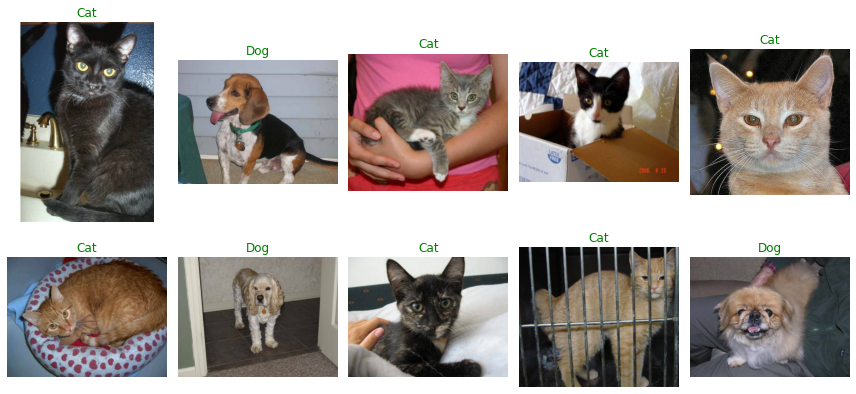

In [ ]:
display_image_grid(test_images_filepaths)

In [ ]:
# 이미지 데이터셋 클래스 정의
class DogvsCatDataset(Dataset):
  def __init__(self, file_list, transform = None, phase = 'train'): # 데이터셋의 전처리 (데이터 변형 적용)
    self.file_list = file_list
    self.transform = transform # DogvsCatDataset 클래스를 호출할 때 transform에 대한 매개변수를 받아옵니다.
    self.phase = phase # train적용

  def __len__(self): # images_filepaths 데이터셋의 전체 길이를 반환
    return len(self.file_list)

  def __getitem__(self, idx): # 데이터셋에서 데이터를 가져오는 부분으로 결과는 텐서 형태가 됩니다.
    img_path = self.file_list[idx]
    img = Image.open(img_path) # img_path 위치에서 이미지 데이터들을 가져옵니다.
    img_transformed = self.transform(img, self.phase) # 이미지에 train 전처리를 적용
    label = img_path.split('/')[-1].split('.')[0] # (dog, cat) 레이블 값을 가져옵니다.
    if label == 'dog':
      label = 1
    elif label == 'cat':
      label = 0
    return img_transformed, label

In [ ]:
# 변수 값 정의
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
# 이미지 데이터셋 정의
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train') # 훈련 이미지에 train_transforms를 적용
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val') # 검증 이미지에 test_transforms를 적용

In [ ]:
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [ ]:
# 데이터로더 정의
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True) # 파이토치의 데이터로더는 배치 관리를 담당합니다. 한 번에 모든 데이터를 불러오면 메모리에 부담을 줄 수 있기 때문에 데이터를 그룹으로 쪼개서 조금씩 불러옵니다.
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader} # 훈련 데이터셋과 검증 데이터셋을 합쳐서 표현

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size(), label)

torch.Size([32, 3, 224, 224]) tensor([1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0])


In [ ]:
# 모델의 네트워크 클래스 (LeNet)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 1, padding = 0)# 2D 합성곱층이 적용됩니다. 입력 형태는 (3, 244, 244)가 되며 출력 형태는 (weight - kernel_size + 1) / stride에 따라 (16, 220, 220) 이 됩니다.
        self.relu1 = nn.ReLU() # ReLU 활성화 함수입니다.
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2) # 최대 풀링이 적용됩니다. 출력 형태는 220 / 2가 되어 (16, 110, 110)가 됩니다.
        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 0) # 또다시 2D 합성곱층이 적용되어 출력 형태는 (32, 106, 106)이 됩니다.

        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2) # 최대 풀링이 적용되어 출력 형태는 (32, 53, 53)입니다.

        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim = 1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)

        #완전연결층에 데이터를 전달하기 위해 데이터 형태를 1차원으로 바꿉니다.
        out = out.view(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu5(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

Conv2d 계층에서의 출력 크기 구하는 공식
출력 크기 = (W - F + 2P) / S + 1
  - W: 입력 데이터의 크기(input_volume_size)
  - F: 커널 크기 (kernel_size)
  - P: 패딩 크기 (padding_size)
  - S: 스트라이드 (strides)

MaxPool2d 계층에서의 풀력 크기 구하는 공식
출력 크기 = (IF / F)
  - IF: 입력 필터의 크기 (input_filter_size, 또한 바로 앞의 Conv2d의 출력 크기이기도 합니다.)
  - F: 커널 크기 (kernel_size)

In [ ]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


출력 결과가 한눈에 들어오지 않는다면 torchsummary 라이브러리를 사용해 볼 수 있습니다. torchsummary는 케라스와 같은 형태로 모델을 출력해 볼 수 있는 라이브러리입니다.

In [ ]:
pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchsummary import summary

summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 2]           1,026
          Softmax-10                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Es

In [ ]:
# 다음은 모델의 학습 가능한 파라미터 수를 model.parameters()를 이용하여 확인해 보겠습니다. 전반적인 코드의 흐름과는 관련이 없는 부분이지만 정보 확인을 위한 코드입니다.
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) # 경사 하강법으로 모멘텀 SGD를 사용 (모멘텀 SGD는 SGD에 관성이 추가된 것으로 매번 기울기를 구하지만 가중치를 수정하기 전에 이전 수정 방향(+,-)을 참고하여 같은 방향으로 일정한 비율만 수정되게 하는 방법입니다.)
# 첫번째 파라미터: 경사 하강법을 통해 궁극적으로 업데이트하고자 하는 파라미터는 가중치(weight)와 바이어스(bias)입니다. lr: 가중치를 변경할 때 얼마나 크게 변경할지 결정합니다. momentum: SGD를 적절한 방향으로 가속화하며 흔들림(진동)을 줄여 주는 매개변수입니다.
criterion = nn.CrossEntropyLoss()

In [ ]:
# 모델의 파라미터와 손실 함수를 CPU에 할당
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# 모델 학습 함수 정의
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
  since = time.time()
  best_acc = 0.0

  for epoch in range(num_epoch): # epoch를 10으로 설정했으므로 10회 반복
    print('Epoch {}/{}'.format(epoch + 1, num_epoch))
    print('-'*20)

    for phase in ['train','val']:
      if phase == 'train':
        model.train() # 모델을 학습시키겠다는 의미
      else:
        model.eval()

      epoch_loss = 0.0
      epoch_corrects = 0.0

      for inputs, labels in tqdm(dataloader_dict[phase]): # 여기에서 dataloader_dict는 훈련 데이터셋을 의미
        inputs = inputs.to(device) # 훈련 데이터셋을 CPU에 할당
        labels = labels.to(device)
        optimizer.zero_grad() # 역전파 단계를 실행하기 전에 기울기를 0으로 초기화

        with torch.set_grad_enabled(phase == 'train'): # phase == 'train'이면 grad 그래디언트 계산 활성화
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, outputs) # 손실 함수를 이용한 오차 계산

          if phase == 'train':
            loss.backward() # 모델의 학습 가능한 모든 파라미터에 대해 기울기를 계산
            optimizer.step() # optimizer의 step 함수를 호출하면 파라미터를 갱신

          epoch_loss += loss.item() * inputs.size(0) # 오차와 입력을 곱하는 이유: 손실 함수의 reduction이라는 파라미터 때문에
          # reduction 파라미터의 기본값은 mean입니다. mean은 정답과 예측 값의 오차를 구한 후 그 값들의 평균을 반환합니다. 즉, 손실 함수 특성상 전체 오차를 배치 크기로 나눔으로써 평균을 반환하기 때문에 epoch_loss를 계산하는 동안 loss.item()과 inputs.size(0)을 곱해 줍니다.
          epoch_corrects += torch.sum(preds == labels.data) # 정답과 예측이 일치하면 그것의 합계를 epoch_corrects에 저장

        epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset) # 최종 오차 계산(오차를 데이터셋의 길이(개수)로 나누어서 계산)
        epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset) # 최종 정확도

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if phase == 'val' and epoch_acc > best_acc: # 검증 데이터셋에 대한 가장 최적의 정확도를 저장
          best_acc = epoch_acc
          best_model_wts = model.state_dict()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}',format(best_acc))

  return model


In [ ]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-28-e610e00e7ca2>:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]): # 여기에서 dataloader_dict는 훈련 데이터셋을 의미


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0325
train Loss: 0.0251 Acc: 0.0700
train Loss: 0.0251 Acc: 0.1150
train Loss: 0.0251 Acc: 0.1550
train Loss: 0.0251 Acc: 0.1975
train Loss: 0.0251 Acc: 0.2350
train Loss: 0.0251 Acc: 0.2725
train Loss: 0.0251 Acc: 0.3225
train Loss: 0.0251 Acc: 0.3625
train Loss: 0.0251 Acc: 0.3950
train Loss: 0.0251 Acc: 0.4300
train Loss: 0.0251 Acc: 0.4850
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0400
train Loss: 0.0251 Acc: 0.0775
train Loss: 0.0251 Acc: 0.1300
train Loss: 0.0251 Acc: 0.1725
train Loss: 0.0251 Acc: 0.2150
train Loss: 0.0251 Acc: 0.2550
train Loss: 0.0251 Acc: 0.2850
train Loss: 0.0251 Acc: 0.3225
train Loss: 0.0251 Acc: 0.3700
train Loss: 0.0251 Acc: 0.4175
train Loss: 0.0251 Acc: 0.4550
train Loss: 0.0251 Acc: 0.4875
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0525
train Loss: 0.0251 Acc: 0.0925
train Loss: 0.0251 Acc: 0.1300
train Loss: 0.0251 Acc: 0.1700
train Loss: 0.0251 Acc: 0.2050
train Loss: 0.0251 Acc: 0.2400
train Loss: 0.0251 Acc: 0.2800
train Loss: 0.0251 Acc: 0.3325
train Loss: 0.0251 Acc: 0.3800
train Loss: 0.0251 Acc: 0.4150
train Loss: 0.0251 Acc: 0.4550
train Loss: 0.0251 Acc: 0.4900
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0350
train Loss: 0.0251 Acc: 0.0825
train Loss: 0.0251 Acc: 0.1175
train Loss: 0.0251 Acc: 0.1625
train Loss: 0.0251 Acc: 0.2025
train Loss: 0.0251 Acc: 0.2450
train Loss: 0.0251 Acc: 0.3000
train Loss: 0.0251 Acc: 0.3325
train Loss: 0.0251 Acc: 0.3700
train Loss: 0.0251 Acc: 0.4125
train Loss: 0.0251 Acc: 0.4475
train Loss: 0.0251 Acc: 0.4875
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0325
train Loss: 0.0251 Acc: 0.0650
train Loss: 0.0251 Acc: 0.1050
train Loss: 0.0251 Acc: 0.1400
train Loss: 0.0251 Acc: 0.1800
train Loss: 0.0251 Acc: 0.2175
train Loss: 0.0251 Acc: 0.2675
train Loss: 0.0251 Acc: 0.3100
train Loss: 0.0251 Acc: 0.3550
train Loss: 0.0251 Acc: 0.3925
train Loss: 0.0251 Acc: 0.4350
train Loss: 0.0251 Acc: 0.4725
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0450
train Loss: 0.0251 Acc: 0.0825
train Loss: 0.0251 Acc: 0.1250
train Loss: 0.0251 Acc: 0.1700
train Loss: 0.0251 Acc: 0.2050
train Loss: 0.0251 Acc: 0.2600
train Loss: 0.0251 Acc: 0.2975
train Loss: 0.0251 Acc: 0.3400
train Loss: 0.0251 Acc: 0.3725
train Loss: 0.0251 Acc: 0.4075
train Loss: 0.0251 Acc: 0.4425
train Loss: 0.0251 Acc: 0.4875
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0375
train Loss: 0.0251 Acc: 0.0775
train Loss: 0.0251 Acc: 0.1275
train Loss: 0.0251 Acc: 0.1700
train Loss: 0.0251 Acc: 0.2050
train Loss: 0.0251 Acc: 0.2425
train Loss: 0.0251 Acc: 0.2800
train Loss: 0.0251 Acc: 0.3175
train Loss: 0.0251 Acc: 0.3575
train Loss: 0.0251 Acc: 0.4075
train Loss: 0.0251 Acc: 0.4425
train Loss: 0.0251 Acc: 0.4800
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0425
train Loss: 0.0251 Acc: 0.0925
train Loss: 0.0251 Acc: 0.1300
train Loss: 0.0251 Acc: 0.1625
train Loss: 0.0251 Acc: 0.1875
train Loss: 0.0251 Acc: 0.2300
train Loss: 0.0251 Acc: 0.2800
train Loss: 0.0251 Acc: 0.3250
train Loss: 0.0251 Acc: 0.3700
train Loss: 0.0251 Acc: 0.4075
train Loss: 0.0251 Acc: 0.4500
train Loss: 0.0251 Acc: 0.4875
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0500
train Loss: 0.0251 Acc: 0.0900
train Loss: 0.0251 Acc: 0.1300
train Loss: 0.0251 Acc: 0.1650
train Loss: 0.0251 Acc: 0.2000
train Loss: 0.0251 Acc: 0.2325
train Loss: 0.0251 Acc: 0.2650
train Loss: 0.0251 Acc: 0.3175
train Loss: 0.0251 Acc: 0.3575
train Loss: 0.0251 Acc: 0.4000
train Loss: 0.0251 Acc: 0.4450
train Loss: 0.0251 Acc: 0.4800
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.0251 Acc: 0.0425
train Loss: 0.0251 Acc: 0.0800
train Loss: 0.0251 Acc: 0.1275
train Loss: 0.0251 Acc: 0.1575
train Loss: 0.0251 Acc: 0.2000
train Loss: 0.0251 Acc: 0.2400
train Loss: 0.0251 Acc: 0.2825
train Loss: 0.0251 Acc: 0.3125
train Loss: 0.0251 Acc: 0.3575
train Loss: 0.0251 Acc: 0.4000
train Loss: 0.0251 Acc: 0.4350
train Loss: 0.0251 Acc: 0.4800
train Loss: 0.0126 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.1090 Acc: 0.1848
val Loss: 0.1101 Acc: 0.3478
val Loss: 0.0965 Acc: 0.5109
Training complete in 7m 4s
Best val Acc: {:4f} 0.5108695652173914


In [ ]:
# 모델 테스트를 위한 함수 정의
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad(): # 역전파 중 텐서들에 대한 변화도를 계산할 필요가 없음을 나타내는 것으로, 훈련 데이터셋의 모델 학습과 가장 큰 차이점입니다.
  for test_path in test_images_filepaths: # 테스트 데이터셋 이용
    img = Image.open(test_path)
    _id = test_path.split('/')[-1].split('.')[1]
    transform = ImageTransform(size, mean, std)
    img = transform(img, phase = 'val') # 테스트 데이터셋 전처리 적용
    img = img.unsqueeze(0) # 차원 추가
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs, dim = 1)[:, 1].tolist()
    id_list.append(_id)
    pred_list.append(preds[0])

  res = pd.DataFrame({
      'id': id_list,
      'label': pred_list
  }) # 테스트 데이터셋의 예측 결과인 id와 레이블(label)을 데이터 프레임에 저장

  res.sort_values(by = 'id', inplace = True)
  res.reset_index(drop = True, inplace = True)

  res.to_csv('LeNet', index = False) # 데이터 프레임을 csv 파일로 저장

torch.unsqueeze는 텐서에 차원을 추가할 때 사용합니다. 또한, (0)은 차원이 추가될 위치를 의미합니다.
예를 들어 형태 (3)인 텐서가 있다고 가정할 때, 0 위치에 차원을 추가하면 형태가 (1, 3)이 됩니다. 즉, 행 한 개와 열 세 개의 구조를 갖는 텐서가 만들어집니다.
형택가 (2,2)인 2D 텐서가 있을 때 0위치에 차원을 추가하면 텐서 모양이 (1,2,2)가 됩니다. 이는 하나의 채널, 행 두 개와 열 두 개를 의미합니다.
1위치에 차원을 추가하면 (2,1,2)의 형태가 되므로 채널 두 개, 행 한 개, 열 두 개가 됩니다.

소프트맥스(softmax)는 지정된 차원(dim)을 따라 텐서의 요소(텐서의 개별 값)가 (0,1) 범위에 있고 합계가 1이 되도록 크기를 다시 조정합니다.

In [ ]:
# 테스트 데이터셋의 예측 결과 호출
res.head(10)

,id,label
0,109,0.731059
1,145,0.731058
2,15,0.731054
3,162,0.731057
4,167,0.731055
5,200,0.731059
6,210,0.731059
7,211,0.731059
8,213,0.731057
9,224,0.731057


예측 결과 레이블이 0.5보다 크면 개를 의미하고, 0.5보다 작으면 고양이를 의미합니다.

In [ ]:
class_ = classes = {0: 'cat', 1: 'dog'} # 개와 고양이에 대한 클래스 정의
def display_image_grid(images_filepaths, predicted_labels = (), cols = 5):
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12, 6))
  for i, image_filepath in enumerate(images_filepaths):
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    a = random.choice(res['id'].values) # 데이터 프레임의 id라는 칼럼에서 임의로 데이터를 가져옵니다.
    label = res.loc[res['id'] == a, 'label'].values[0]
    if label > 0.5: # 레이블 값이 0.5보다 크다면 개
      label = 1
    else: # 레이블 값이 0.5보다 작다면 고양이
      label = 0

    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off()

  plt.tight_layout()
  plt.show()

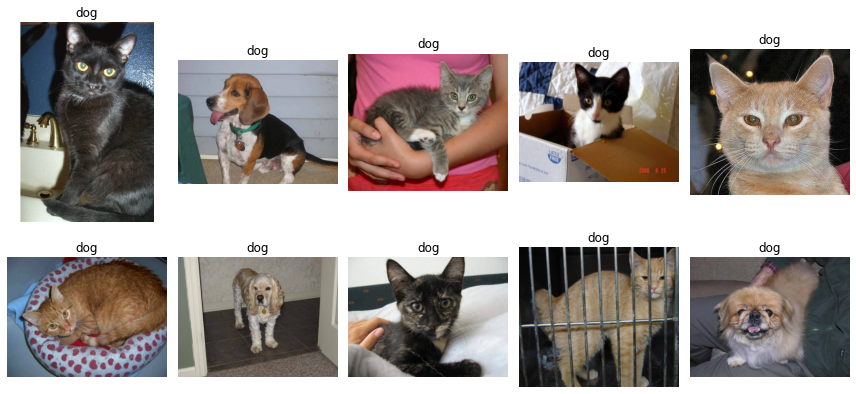

In [ ]:
display_image_grid(test_images_filepaths)

### AlexNet

AlexNet은 ImageNet 영상 데이터베이스를 기반으로 한 화상 인식 대회인 'ILSVRC 2012'에서 우승한 CNN 구조입니다.
CNN은 3차원 구조를 갖는다는 것을 이해해야 합니다(이미지를 다루기 때문에 기본적으로 3차원 데이터를 다룹니다.) 이미지 크기를 나타내는 너비와 높이 뿐만 아니라 깊이를 갖습니다. 보통 색상이 많은 이미지는 RGB성분 세 개를 갖기 때문에 시작이 3이지만, 합성곱을 거치면서 특성 맵이 만들어지고 이것에 따라 중간 영상의 깊이가 달라집니다.

AlexNet은 합성곱층 총 다섯 개와 완전연결층 세 개로 구성되어 있으며, 맨 마지막 완전연결층은 카테고리 1000개를 분류하기 위해 소프트맥스 활성화 함수를 사용하고 있습니다. 전체적으로 보면 GPU 두 개를 기반으로 한 병렬 구조인 점을 제외하면 LeNet-5와 크게 다르지 않습니다.

네트워크에는 학습 가능한 변수가 총 6600만 개 있습니다. 네트워크에 대한 입력은 227 x 227 x 3 크기의 RGB 이미지이며, 각 클래스(혹은 카테고리)에 해당하는 1000 x 1 확률 벡터를 출력합니다.

AlexNet의 첫 번째 합성곱층 커널의 크기는 11 x 11 x 3이며, 스트라이드를 4로 적용하여 특성맵을 96개 생성하기 때문에 55 x 55 x 96의 출력을 갖습니다. 첫 번째 계층을 거치면서 GPU-1에서는 주로 컬러와 상관없는 정보를 추출하기 위한 커널이 학습되고, GPU-2에서는 주로 컬러와 관련된 정보를 추출하기 위한 커널이 학습됩니다.

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

원래 AlexNet의 마지막 계층에는 뉴런이 1000개 있지만 예제에서는 클래스(개, 고양이) 두 개만 사용합니다.

In [ ]:
class ImageTransform():
    def __init__(self, resize, std, mean):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),

            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
      return self.data_transform[phase](img)

In [ ]:
cat_directory = r'/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/drive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Dog'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

In [ ]:
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]

In [ ]:
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [ ]:
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


AlexNet은 파라미터를 6000만 개 사용하는 모델입니다. 이때 충분한 데이터가 없으면 과적합이 발생하는 등 테스트 데이터에 대한 성능이 좋지 않습니다.
성능이 좋아질려면 캐글에서 내려받은 모든 이미지를 사용하는 것뿐만 아니라 전처리 부분에서 데이터를 많이 확장(randomRotation, RandomHorizontalFlip 등을 이용)시켜 예제를 진행해야 합니다.

In [ ]:
# torch.utils.data.Dataset을 상속받아 커스텀 데이터셋(custom dataset)을 정의합니다.

class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform = None, phase = 'train'):
      self.file_list = file_list
      self.transform = transform
      self.phase = phase

    def __len__(self):
      return len(self.file_list)

    def __getitem__(self, idx):
      img_path = self.file_list[idx] # 이미지 데이터의 인덱스를 가져오기
      img = Image.open(img_path)
      img_transformed = self.transform(img, self.phase)

      label = img_path.split('/')[-1].split('.')[0] # 레이블 값을 가져오기
      if label == 'dog':
        label = 1
      elif label == 'cat':
        label = 0

      return img_transformed, label # 전처리가 적용된 이미지와 레이블 반환

In [ ]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val')

index = 0
print(train_dataset.__getitem__(index)[0].size()) # 훈련 데이터셋의 크기는 (채널, 너비, 높이)를 의미합니다.
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [ ]:
# 데이터셋을 메모리로 불러옴
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 256, 256])
tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 0, 1])


AlexNet
합성곱(Conv2d) + 활성화 함수(ReLU) + 풀링(MaxPool2d) 다섯 번 반복된 후 두개의 완전연결층과 출력층으로 구성된 네트워크

In [ ]:
# AlexNet 모델 네트워크 정의

class AlexNet(nn.Module):
    def __init__(self) -> None:
      super(AlexNet, self).__init__()
      self.features = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2),
          nn.ReLU(inplace = True),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.Conv2d(64, 192, kernel_size = 5, padding = 2),
          nn.ReLU(inplace = True),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.Conv2d(192, 384, kernel_size = 3, padding = 1),
          nn.ReLU(inplace = True),
          nn.Conv2d(384, 256, kernel_size = 3, padding = 1),
          nn.ReLU(inplace = True),
          nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
          nn.ReLU(inplace = True),
          nn.MaxPool2d(kernel_size = 3, stride = 2)
      )
      self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
      self.classifier = nn.Sequential(
          nn.Dropout(),
          nn.Linear(256*6*6, 4096),
          nn.ReLU(inplace = True),
          nn.Dropout(),
          nn.Linear(4096, 512),
          nn.ReLU(inplace = True),
          nn.Linear(512, 2)
      )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
      x = self.features(x)
      x = self.avgpool(x)
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x

ReLU 활성화 함수에서 inplace = True 의미에 대해 대략 살펴보았습니다.
inplace 연산이란 연산에 대한 결과값을 새로운 변수에 저장하는 것이 아닌 기존 데이터를 대체하는 것을 의미합니다. 즉, 기본 값을 연산 결과값으로 대체함으로써 기존 값들을 무시하겠다는 의미입니다.

nn.AdaptiveAVGPool2d는 nn.AvgPool2d처럼 풀링을 위해 사용합니다. AvgPool2d에서는 풀링에 대한 커널 및 스트라이드 크기를 정의해야 동작합니다. 예를 들어 nn.AvgPool2d((3, 2), stride = (2, 1))처럼 지정하면 그 결과는 5x5 텐서를 3x3 텐서로, 7x7텐서를 4x4텐서로 줄이는 효과를 얻을 수 있습니다. 조금 더 정확히 표현하자면, (N, C, H(in), W(in)) 크기의 입력을, (N, C, H(out), W(out)) 크기로 출력하는 것이 AvgPool2d입니다.

반면에 AdaptiveAvgPool2d는 풀링 작업이 끝날 때 필요한 출력 크기를 정의합니다. 즉, nn.AvgPool2d에서는 커널 크기, 스트라이드, 패딩을 지정했다면 nn.AdaptiveAvgPool2d는 출력에 대한 크기만 지정합니다. 따라서 AdaptiveAvgPool2d를 사용할 경우 출력 크기에 대한 조정이 상당히 쉬워집니다. 참고로 AdaptiveAvgPool2d는 입력 크기에 변동이 있고 CNN 위쪽에 완전연결층을 사용하는 경우 유용합니다.

In [ ]:
# model 객체 생성
model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
from torchsummary import summary
summary(model, input_size = (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
# 모델 학습 함수 정의

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
  since = time.time()
  best_acc = 0.0

  for epoch in range(num_epoch):
    print('Epoch {}/{}'.format(epoch + 1, num_epoch))

    print('-' * 20)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()

      else:
        model.eval()

      epoch_loss = 0.0
      epoch_corrects = 0

      for inputs, labels in tqdm(dataloader_dict[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward() # 모델의 학습 가능한 모든 파라미터에 대해 기울기를 계산
            optimizer.step() # 파라미터 갱신

          epoch_loss += loss.item() * inputs.size(0)
          epoch_corrects += torch.sum(preds == labels.data)

      epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
      epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  return model

In [ ]:
num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-101-b8c2701e3cad>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6940 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6933 Acc: 0.5000
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5000
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6929 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927 Acc: 0.5000
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.4925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6926 Acc: 0.5000
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.4950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6925 Acc: 0.6739
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5100


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.5761
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6925 Acc: 0.5150


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6920 Acc: 0.5000
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6927 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6918 Acc: 0.5000
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6924 Acc: 0.5000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6914 Acc: 0.5109
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6921 Acc: 0.5125


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6910 Acc: 0.5000
Training complete in 12m 27s


In [ ]:
# 모델을 이용한 에측

import pandas as pd

id_list = []
pred_list = []
_id = 0
with torch.no_grad():
  for test_path in tqdm(test_images_filepaths): # 테스트 이미지 데이터 이용
    img = Image.open(test_path)
    _id = test_path.split('/')[-1].split('.')[0]
    transform = ImageTransform(size, mean, std)
    img = transform(img, phase = 'val')
    img = img.unsqueeze(0) # 차원 추가 0이니까 맨 앞에 차원이 추가됨
    img = img.to(device)

    model.eval()
    outputs = model(inputs)
    preds = F.softmax(outputs, dim = 1)[:, 1].tolist()

    id_list.append(_id)
    pred_list.append(preds[0])

res = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})

res.to_csv('alexnet.csv', index = False)

<ipython-input-104-dd6d5aa11d5a>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths): # 테스트 이미지 데이터 이용


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
res.head(10)

,id,label
0,cat,0.497522
1,dog,0.497522
2,dog,0.497522
3,cat,0.497522
4,cat,0.497522
5,dog,0.497522
6,cat,0.497522
7,cat,0.497522
8,dog,0.497522
9,dog,0.497522


In [ ]:
# 예측 결과를 시각적으로 표현하기 위한 함수 정의

class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels = {}, cols = 5):
  rows = len(images_filepaths) // cols
  figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize = (12, 6))
  for i, image_filepath in enumerate(images_filepaths):
    image = cv2.imread(image_filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    a = random.choice(res['id'].values)
    label = res.loc[res['id'] == a, 'label'].values[0]
    if label > 0.5:
      label = 1
    else:
      label = 0

    ax.ravel()[i].imshow(image)
    ax.ravel()[i].set_title(class_[label])
    ax.ravel()[i].set_axis_off()

  plt.tight_layout()
  plt.show()

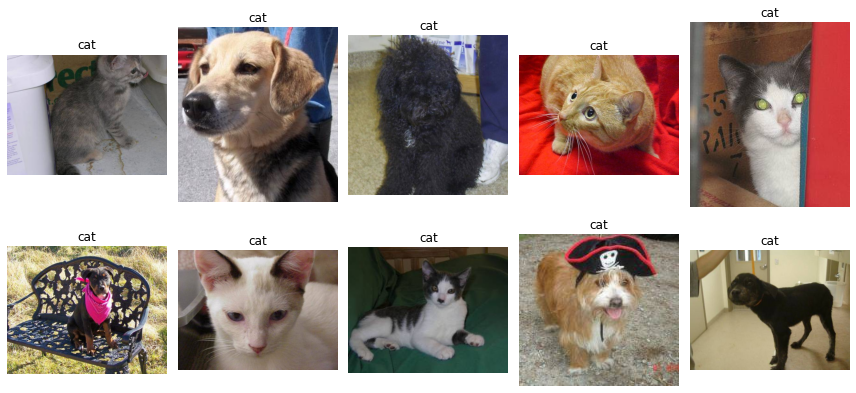

In [ ]:
display_image_grid(test_images_filepaths)

### VGGNet

VGGNet은 합성곱층의 파라미터 수를 줄이고 훈련 시간을 개선하려고 탄생했습니다.
즉, 네트워크를 깊게 만드는 것이 성능에 어떤 영향을 미치는지 확인하고자 나온 것이 VGG입니다.
VGG 연구 팀은 깊이의 영향만 최대한 확인하고자 합성곱층에서 사용하는 필터/커널의 크기를 가장 작은 3x3으로 고정했습니다.
네트워크 계층의 총 개수에 따라 여러 유형의 VGGNet(VGG16, VGG19 등)이 있으며, 이 중 VGG에는 파라미터가 총 1억 3300만 개가 있습니다. 여기서 주목할 점은 모든 합성곱 커널의 크기는 3x3, 최대 풀링 커널의 크기는 2x2이며, 스트라이트는 2라는 것입니다. 결과적으로 64개의 244x244 특성 맵(244x244x64)들이 생성됩니다. 또한, 마지막 16번째 계층을 제외하고는 모두 ReLU 활성화 함수가 적용됩니다.

**VGG11 구현**

In [ ]:
# 필요한 라이브러리 호출

import copy # 객체 복사를 위해 사용합니다. 객체 복사는 크게 얕은 복사(shallow copy)와 깊은 복사(deep copy)로 나뉩니다.
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as Datasets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 파이토치는 텐서플로와 다르게 GPU를 자동으로 할당해 주지 않기 때문에 GPU 할당을 모델과 데이터에 선언해 주어야 합니다. 단 이장에서는 CPU를 사용합니다.

In [ ]:
# 단순한 객체 복사
original = [1, 2, 3]
copy_o = original
print(copy_o)

[1, 2, 3]


In [ ]:
copy_o[2] = 10
print(copy_o)
print(original)

[1, 2, 10]
[1, 2, 10]


In [ ]:
# 얕은 복사
# 메모리가 한 개

import copy

original = [[1,2], 3]
copy_o = copy.copy(original)
print(copy_o)
copy_o[0] = 100
print(copy_o)
print(original)

[[1, 2], 3]
[100, 3]
[[1, 2], 3]


In [ ]:
# 깊은 복사
# 메모리가 두 개

import copy

original = [[1, 2], 3]
copy_o = copy.deepcopy(original) # original 값을 copy_o에 깊은 복사(copy.deepcopy())
print(copy_o)
copy_o[0] = 10
print(copy_o)
print(original)

append = copy.deepcopy(original)
append[0].append(4)
print(append)
print(original)

[[1, 2], 3]
[10, 3]
[[1, 2], 3]
[[1, 2, 4], 3]
[[1, 2], 3]


In [ ]:
class VGGNet(nn.Module):
    def __init__(self, features, output_dim):
      super(VGGNet, self).__init__()
      self.features = features # VGG 모델에 대한 매개 변수에서 받아 온 features 값을 self.features에 넣어 줍니다.
      self.avgpool = nn.AdaptiveAvgPool2d(7)
      self.classifier = nn.Sequential(
          nn.Linear(512*7*7, 4096),
          nn.ReLU(inplace = True),
          nn.Dropout(0.5),
          nn.Linear(4096, 4096),
          nn.ReLU(inplace = True),
          nn.Dropout(0.5),
          nn.Linear(4096, output_dim)
      )

    def forward(self, x):
      x = self.features(x)
      x = self.avgpool(x)
      h = x.view(x.shape[0], -1)
      x = self.classifier(x)
      return x, h

In [ ]:
# 모델 유형 정의

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'] # 8(합성곱층) + 3(풀링층) = 11(전체 계층) = VGG11
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'] # 10(합성곱층) + 3(풀링층) = 13(전체 게층) = VGG13
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'] # 13(합성곱층) + 3(풀링층) = 16(전체 계층) = VGG16
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'] # 16(합성곱층) + 3(풀링층) = 19(전체 계층) = vGG19

In [ ]:
# VGG 계층 정의

def get_vgg_layers(config, batch_norm):
  layers = []
  in_channels = 3

  for c in config: # vgg11_config 값들을 가져옵니다.
    assert c == 'M' or isinstance(c, int) # c가 'M'이거나 int가 아니면 오류 발생
    if c == 'M': # 불러온 값이 'M'이면 최대 풀링(MaxPool2d)을 적용
      layers += [nn.MaxPool2d(kernel_size = 2)]
    else: # 불러온 값이 숫자이면 합성곱(Conv2d) 적용
      conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
      if batch_norm: # 배치 정규화(batch normalization)를 적용할지에 대한 코드
        layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)] # 배치 정규화가 적용될 경우 배치 정규화 + ReLU 적용
      else:
        layers += [conv2d, nn.ReLU(inplace = True)] # 배치 정규화가 적용되지 않을 경우 ReLU만 적용
      in_channels = c

  return nn.Sequential(*layers) # 네트워크의 모든 계층을 반환

In [ ]:
# 모델 계층 생성
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

batch_norm(Batch Normalization)은 데이터의 평균을 0으로 하고, 표준편차를 1로 분포시키는 것입니다. 각 계층에서 입력 데이터의 분포는 앞 계층에서 업데이트된 가중치에 따라 변환합니다.
즉, 각 계층마다 변화되는 분포는 학습 속도를 늦출 뿐만 아니라 학습도 어렵게 합니다. 따라서 각 계층의 입력에 대한 분산을 평균 0, 표준편차 1로 분포시키는 것이 batch_norm(배치 정규화)입니다.

In [ ]:
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
# VGG11 전체에 대한 네트워크

OUTPUT_DIM = 2 # 개와 고양이
model = VGGNet(vgg11_layers, OUTPUT_DIM)
print(model)

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d

사실 VGG모델은 사전 훈련된 모델입니다.
누군가 대용량의 이미지 데이터로 학습을 시켰으며, 최상의 상태로 튜닝을 거쳐 모든 사람이 사용할 수 있도록 공유한 사전 훈련된 모델입니다.

In [ ]:
# VGG11 사전 훈련된 모델 사용
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained = True)
print(pretrained_model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)), # 이미지를 주어진 크기로 재조정합니다. 즉 256 x 256 크기로 이미지를 조정합니다.
    transforms.RandomRotation(5), # 5도 이하로 이미지를 회전시킵ㄴ디ㅏ.
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


In [ ]:
from google.colab import drive

drive.mount('/content/Mydrive')

Mounted at /content/Mydrive


In [ ]:
train_path = '/content/Mydrive/MyDrive/080289-main/chap06/data/catanddog/train'
test_path = '/content/Mydrive/MyDrive/080289-main/chap06/data/catanddog/test'

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform = train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform = test_transforms
)

print(len(train_dataset), len(test_dataset))

529 12


In [ ]:
# 훈련과 검증 데이터 분할

VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO) # 전체 훈련 데이터 중 90%를 훈련 데이터셋으로 사용
n_valid_examples = len(train_dataset) - n_train_examples # 전체 훈련 데이터 중 10%를 검증 데이터셋으로 사용

train_data, valid_data = data.random_split(train_dataset, [n_train_examples, n_valid_examples])

In [ ]:
# 검증 데이터 전처리

valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
# 훈련, 검증, 테스트 데이터셋 수 확인

print(f'Number of training examples: {len(train_data)}')
print(f'Number of training examples: {len(valid_data)}')
print(f'Number of training examples: {len(test_dataset)}')

Number of training examples: 476
Number of training examples: 53
Number of training examples: 12


In [ ]:
# 메모리로 데이터 불러오기

BATCH_SIZE = 128
train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE) # 훈련 데이터셋은 임의로 섞어서 가져옵니다.
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_dataset, batch_size = BATCH_SIZE)

In [ ]:
# 옵티마이저와 손실 함수 정의

optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# 모델의 정확도 측정 함수

def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

eq는 equal약자로 서로 같은지를 비교하는 표현식입니다.

view_as(other)는 other의 텐서 크기를 사용하겠다는 의미입니다. 즉, view_as(other)는 view(other.size())와 같은 의미입니다. 따라서 y.view_as(top_pred)는 y에 대한 텐서 크기를 top_pred의 텐서 크기로 변경하겠다는 의미입니다.

그리고 합계를 구하는 것으로, 여기에서는 예측과 정답이 일치하는 것들의 개수를 합산하겠다는 의미입니다.

In [ ]:
# 모델 학습 함수 정의
def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for (x, y) in iterator:
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    y_pred, _ = model(x)
    loss = criterion(y_pred, y)
    acc = calculate_accuracy(y_pred, y)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# 모델 성능 측정 함수
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = calculate_accuracy(y_pred, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
# 학습 시간 측정 함수

def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [ ]:
import time

In [ ]:
# 모델 학습
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
  start_time = time.monotonic()
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device) # 훈련 데이터셋을 모델에 적용한 결과(오차와 정확도)를 train_loss와 train_acc에 적용
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device) # 검증 데이터셋 동일

  if valid_loss < best_valid_loss: # valid_loss가 가장 작은 값을 구하고 그 상태의 모델을 vgg-model.pt 이름으로 저장
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'vgg-model.pt')

  end_time = time.monotonic()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time) # 모델 훈련에 대한 시작과 종료 시간을 저장

  print(f'Epoch: {epoch+1:02} | {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc * 100: .2f}%')
  print(f'Valid Loss: {valid_loss:.3f} | Valid Acc: {valid_acc * 100: .2f}%')

에포크만 늘린다고 성능이 좋아지지는 않기 때문에 데이터도 함께 증강시켜 모델을 학습시켜야합니다.

In [ ]:
# 앞에서 저장했던 모델(VGG-model.pt)을 불러와서 테스트 데이텃세을 이용한 모델 성능 측정

model.load_state_dict(torch.load('vgg-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100: .2f}%')

In [ ]:
# 테스트 데이터셋을 이용한 모델의 예측 확인 함수

def get_predictions(model, iterator):
  model.eval()
  images = []
  labels = []
  probs = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y_pred, _ = model(x)
      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True) # argmax는 배열에서 가장 큰 값의 인덱스를 찾을 때 사용합니다.
      # argmax의 첫번째 파라미터: 행(axis=0) 또는 열(axis=1)을 따라 가장 큰 값의 색인을 찾습니다. 따라서 1은 열을 따라 가장 큰 값의 색인을 찾겠다는 의미입니다.
      # keepdim: keepdim = True의 경우 출력 텐서를 입력과 동일한 크기로 유지하겠다는 의미입니다.
      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim = 0) # torch.cat은 텐서를 연결할 때 사용합니다.
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)

  return images, labels, probs

In [ ]:
# torch.cat 예제

import torch

x = torch.Tensor([[1,2,3], [2,3,4]])
y = torch.Tensor([[4,5,6], [5,6,7]])

print(torch.cat([x], dim = 0)) # 행을 기준(dim = 0)으로 x를 이어 붙입니다.
print(torch.cat([x, y]))
print(torch.cat([x, y], dim = 0))
print(torch.cat([x, y], dim = 1)) # 열을 기준 (dim = 1)으로 x를 이어 붙입니다.

tensor([[1., 2., 3.],
        [2., 3., 4.]])
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [4., 5., 6.],
        [5., 6., 7.]])
tensor([[1., 2., 3.],
        [2., 3., 4.],
        [4., 5., 6.],
        [5., 6., 7.]])
tensor([[1., 2., 3., 4., 5., 6.],
        [2., 3., 4., 5., 6., 7.]])


In [ ]:
# 예측 중에서 정확하게 예측한 것을 추출
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels) # 예측과 정답이 같은지 비교
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if correct:
    correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

argmax는 최대값을 갖는 인덱스를 반환합니다.

In [ ]:
# argmax 예제

x = torch.rand(5, 3) # 5x3텐서 생성
print(x)
print(torch.max(x)) # 최대 값을 반환함
print(torch.argmax(x)) #  그 최대 값을 가지고 있는 인덱스를 반환함

zip()은 여러개의 리스트(혹은 튜플)를 합쳐서 새로운 튜플 타입으로 반환합니다.

In [ ]:
a = [1, 2, 3]
b = ['a', 'b', 'c']

for x, y in zip(a, b):
  print(x, y)

1 a
2 b
3 c


데이터를 정렬하기 위해 sort() 메서드를 사용합니다.

reverse: 내림차순으로 정렬합니다.

In [ ]:
x = [1, 7, 3, 9]
x.sort(reverse = True) # 내림차순 정렬
print(x)

[9, 7, 3, 1]


key: 데이터를 정렬할 때 Key 값을 가지고 정렬하며 기본값은 오름차순입니다. 또한 여기서 사용되는 람다는 일종의 함수입니다. 일반적으로 함수는 def 함수명()처럼 사용하지만 람다 함수는 함수명 없이도 사용 가능합니다.

In [ ]:
y = lambda x: x + 10
y(1)

11

torch.max(x[2], dim = 0) 의미는 다음과 같습니다.

In [ ]:
x = torch.randn([4, 4]) # 4x4 임의의 값을 갖는 텐서
print(x)

tensor([[-1.3298, -0.5574, -0.2729,  0.0542],
        [ 0.4066,  0.5414,  1.5474, -0.2667],
        [-0.1395, -0.8663,  1.7907, -0.3274],
        [ 0.6611, -1.2310,  0.1642,  0.2615]])


In [ ]:
max_elements, max_idxs = torch.max(x, dim = 0) # torch.max 값을 가지고 오되 dim = 0(행을 기준)으로 최대값을 가져옵니다.
print(max_elements)
print(max_idxs)

tensor([0.6611, 0.5414, 1.7907, 0.2615])
tensor([3, 1, 2, 3])


In [ ]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max) # torch.clamp는 주어진 최소, 최대의 범주에 이미지가 위치하도록 합니다.
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

torch.add는 말그대로 더하라는 메서드입니다.
torch.add와 torch.add_의 차이는

In [ ]:
x = torch.tensor([1, 2])
y = x.add(10)
print(y)
print(x is y)

print('-' * 10)

x = torch.tensor([1, 2])
y = x.add_(10)
print(y)
print(x is y)

tensor([11, 12])
False
----------
tensor([11, 12])
True


torch.add의 결과는 새로운 메모리 공간이 할당되어 저장되기 때문에 x와 y가 같은지 물었을 때 False라는 결과를 출력한 반면, torch.add_는 새로운 공간 할당 없이 기존의 메모리에 위치한 값을 대체합니다.

참고로 메서드에 _ 표시가 있다면 기존의 메모리 공간에 있는 값을 새로운 값으로 대체하겠다는 의미입니다.

In [ ]:
def plot_most_correct(correct, classes, n_images, normalize = True):
  rows = int(np.sqrt(n_images)) # np.sqrt는 제곱근을 계산(0.5를 거듭제곱)
  cols = int(np.sqrt(n_images))
  fig = plt.figure(figsize = (25, 20))
  for i in range(rows * cols):
    ax = fig.add_subplot(rows, cols, i+1) # 출력하려는 그래프 개수만큼 subplot을 만듭니다.
    image, true_label, probs = correct[i]
    image = image.permute(1, 2, 0)
    true_prob = probs[true_label]
    correct_prob, correct_label = torch.max(probs, dim = 0)
    true_class = classes[true_label]
    correct_class = classes[correct_label]

    if normalize: # 본래 이미지대로 출력하기 위해 normalize_image 함수 호출
      image = normalize_image(image)

    ax.imshow(image.cpu().numpy())
    ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' f'pred label: {correct_class} ({correct_prob:.3f})')
    ax.axis('off')

  fig.subplots_adjust(hspace = 0.4)

image.permute는 축을 변경할 때 사용합니다.

In [ ]:
x = torch.tensor([1, 2, 3], [4, 5, 6])
print(x)
x.permute(1, 0) # 차원(축) 0과 1을 바꿉니다. (행과 열이 변경됨)

In [ ]:
# 모델이 정확하게 예측한 이미지에 대한 출력 결과

classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)

## GoogLENet

GoogLeNet은 주어진 하드웨어 자원을 최대한 효율적으로 이용하면서 학습 능력은 극대화할 수 있는 깊고 넓은 신경망입니다.

깊고 넓은 신경망을 위해 GoogLENet은 인셉션(inception) 모듈을 추가했습니다. 인셉션 모듈에서는 특징을 효율적으로 추출하기 위해 1x1, 3x3, 5x5의 합성곱 연산을 각각 수행합니다.
3x3 최대 풀링은 입력과 출력의 높이와 너비가 같아야 하므로 풀링 연산에서는 드물게 패딩을 추가해야 합니다. 결과적으로 GoogLeNet에 적용된 해결 방법은 희소 연결(sparse conectivity)입니다.

CNN은 합성곱, 풀링, 완전연결층들이 서로 밀접(dense)(정교하고 빽빽하게)하게 연결 되어 있습니다. 빽빽하게 연결된 신경망 대신 관련성(correlation)이 높은 노드끼리만 연결하는 방법을 희소 연결이라고 합니다. 이것으로 연산량이 적어지며 과적합도 해결할 수 있습니다.

인셉션 모듈의 네 가지 연산
- 1x1 합성곱
- 1x1 합성곱 + 3x3 합성곱
- 1x1 합성곱 + 5x5 합성곱
- 3x3 최대 풀링(maxpooling) + 1x1 합성곱

딥러닝을 이용하여 ImageNet과 같은 대회에 참여하거나 서비스를 제공하려면 대용량 데이터를 학습해야 합니다. 심층 신경망의 아키텍처에서 계층이 넓고(뉴런이 많고) 깊으면(계층이 많으면) 인식률은 좋아지지만, 과적합이나 기울기 소멸 문제(vanishing gradient problem)를 비롯한 학습 시간 지연과 연산 속도 등의 문제가 있습니다. 특히 합성곱 신경망에서 이러한 문제들이 자주 나타나는데, GoogLeNet(혹은 인셉션이라고도 불림)으로 이러한 문제를 해결할 수 있습니다.

## ResNet

ResNet은 마이크로소프트에서 개발한 알고리즘으로 Deep Residual Learning for Image Recognition 이라는 논문에서 발표되었습니다. ResNet 핵심은 깊어진 신경망을 효과적으로 학습하기 위한 방법으로 레지듀얼(residual) 개념을 고안한 것입니다.
일반적으로 신경망 깊이가 깊어질수록 딥러닝 성능은 좋아질 것 같지만, 실상은 아닙니다.
논문에 따르면 신경망은 깊이가 깊어질수록 성능이 좋아지다가 일정한 단계에 다다르면 오히려 성능이 나빠진다고 합니다.

ResNet은 층이 총 152개로 구성되어 기울기 소멸 문제가 발생할 수 있기 때문에 숏컷을 두어 기울기 소멸 문제를 방지했습니다.

묶인 계층들을 하나의 레지듀얼 블록(residual block)이라고 합니다. 그리고 레지듀얼 블록을 여러 개 쌓은 것을 ResNet이라고 합니다.

하지만 이렇게 계층을 계속해서 쌓아 늘리면 파라미터 수가 문제가 됩니다. 계층이 깊어질수록 파라미터는 증가합니다. 따라서 계층의 깊이가 깊어질수록 파라미터는 무제한으로 커질 것입니다. 이러한 문제를 해결하기 위해서 병목 블록(bottleneck block)이라는 것을 두었습니다.

병목 블록을 사용하면 파라미터 수가 감소하는 효과를 줄 수 있습니다.
예를들어 ResNet50에서는 3x3 합성곱층 앞뒤로 1x1 합성곱층이 붙어 있는데,
1x1 합성곱층의 채널 수를 조절하면서 차원을 줄였다 늘리는 것이 가능하기 때문에 파라미터 수를 줄일 수 있었던 것입니다.

이때 중요한 아이덴티티 매핑(identity mapping)(혹은 숏컷(shortcut), 스킵 연결(skip connection)이라고도 함)

In [ ]:
def forward(self, x):
  i = x
  x = self.conv1(x)
  x = self.bn1(x)
  x = self.relu(x)
  x = self.conv2(x)
  x = self.bn2(x)

  if self.downsample is not None:
    i = self.downsample(i) # 다운샘플 적용

  x += I # 아이덴티티 매핑 적용
  x = self.relu(x)
  return x

다운 샘플(downsample)은 특성맵(feature map) 크기를 줄이기 위한 것으로 풀링과 같은 역할을 한다고 이해하면 됩니다.

보라색 영역의 첫 번째 블록에서 특성 맵의 형상이 (28, 28, 64)였다면 세 번째 블록의 마지막 합성곱층을 통과하고 아이덴티티 매핑(identity mapping)까지 완료된 특성 맵의 형상도 (28, 28, 64)입니다.

노란색 영역의 시작 지점에서는 채널 수가 128로 늘어났고, /2라는 것으로 보아 첫번째 블록에서 합성곱층의 스트라이드가 2로 늘어나(14, 14, 128)로 바뀐다는 것을 알 수 있습니다.

즉, 보라색과 노란색의 형태가 다른데 이들 간의 형태를 맞추지 않으면 아이덴티티 매핑을 할 수 없게 됩니다. 그래서 아이덴티티에 대해 다운 샘플이 필요합니다.

참고로 입력과 출력의 형태를 같도록 맞추어 주기 위해서는 스트라이드(stride) 2를 가진 1x1 합성곱 계층을 하나 연결해 주면 됩니다. 이와 같이 입력과 출력의 차원이 같은 것을 아이덴티티 블록이라고 하며, 입력 및 출력 차원이 동일하지 않고 입력의 차원을 출력에 맞추어 변경해야 하는 것을 프로젝션 숏컷(projection shortcut) 혹은 합성곱 블록이라고 합니다.

ResNet은 기본적으로 VGG19 구조를 뼈대로 하며, 거기에 합성곱층들이 추가해서 깊게 만든 후 숏컷들을 추가하는 것이 사실상 전부라고 생각하면 됩니다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple # 네임드 튜플은 파이썬 자료형 중 하나입니다. 말 그대로 튜플의 성질을 갖고 있는 자료형이지만 인덱스 뿐만 아니라 키 값으로 데이터에 접근할 수 있습니다.
import os
import random
import time

import cv2
from torch.utils.data import DataLoader, Dataset
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# namedtuple

from collections import namedtuple

Student = namedtuple('Student', ['name', 'age', 'DOB']) # 네임드 튜플 정의
S = Student('홍길동', '19', '187')

print('The Student age using index is: ', end = "")
print(S[1])

print('The Student name using keyname is ', end = "")
print(S.name)

The Student age using index is: 19
The Student name using keyname is 홍길동


In [ ]:
from google.colab import drive

drive.mount('/content/Mydrive')

Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).


In [ ]:
class ImageTransform():
    def __init__(self, resize, std, mean):
      self.data_transform = {
          'train': transforms.Compose([
              transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean, std)
          ]),
          'val': transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(resize),
              transforms.ToTensor(),
              transforms.Normalize(mean, std)
          ])
      }

    def __call__(self, img, phase):
      return self.data_transform[phase](img)

In [ ]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [ ]:
cat_directory = r'/content/Mydrive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Cat'
dog_directory = r'/content/Mydrive/MyDrive/080289-main/chap06/data/dogs-vs-cats/Dog'
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

In [ ]:
random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]

In [ ]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform = None, phase = 'train'):
      self.file_list = file_list
      self.transform = transform
      self.phase = phase

    def __len__(self):
      return len(self.file_list)

    def __getitem__(self, idx):
      img_path = self.file_list[idx]
      img = Image.open(img_path)
      img_transformed = self.transform(img, self.phase)

      label = img_path.split('/')[-1].split('.')[0]
      if label == 'dog':
        label = 1
      else:
        label = 0

      return img_transformed, label

In [ ]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


In [ ]:
train_iterator = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_iterator = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
dataloader_dict = {'train': train_iterator, 'val': valid_iterator}

In [ ]:
batch_iterator = iter(train_iterator)

In [ ]:
inputs, label = next(batch_iterator)
print(inputs.size(), label)

torch.Size([32, 3, 224, 224]) tensor([1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 0])


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

In [ ]:
class BottleNet(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
        self.downsample = downsample

    def forward(self, x):
        i = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

기본블록이 3x3 합성곱층 두 개를 갖는 반면, 병목 블록은 1x1, 3x3, 1x1 합성곱층의 구조를 갖습니다.
기본 블록을 병목 블록으로 변경하는 이유는 계층을 더 깊게 쌓으면서 계산에 대한 비용을 줄일 수 있기 때문입니다. 그리고 계층이 많아진다는 것은 곧 활성화 함수가 기존보다 더 많이 포함된다는 것이고, 이것은 더 많은 비선형성(non-linearity)을 처리할 수 있음을 의미합니다.

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim, zero_init_residual = False):
      super().__init__()

      block, n_blocks, channels = config # ResNet을 호출할 때 넘겨준 config 값들을 block, n_blocks, channels에 저장
      self.in_channels = channels[0]
      assert len(n_blocks) == len(channels) == 4 # 블록 크기 = 채널 크기 = 4

      self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
      self.bn1 = nn.BatchNorm2d(self.in_channels)
      self.relu = nn.ReLU(inplace = True)
      self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

      self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
      self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
      self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
      self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

      self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
      self.fc = nn.Linear(self.in_channels, output_dim)

      if zero_init_residual: # 각 레지 듀얼 분기(residual branch)에 있는 마지막 BN(batch Normalization)을 0으로 초기화해서 다음 레지듀얼 분기를 0에서 시작할 수 있도록 합니다.
        for m in self.modules(): # 무슨 모듈을 사용했는지 class BottleNet(nn.Module): or class BasicBlock(nn.Module):
          if isinstance(m, BottleNet):
            nn.init.constant_(m.bn3.weight, 0) # .init.constant_(텐서 값, 스칼라 값) : 텐서 위치에 스칼라 값을 초기화 시킴
          elif isinstance(m, BasicBlock):
            nn.init.constant_(m.bn2.weight, 0)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1): # 블록을 추가하기 위한 함수
      layers = []
      if self.in_channels != block.expansion*channels: # in_channels와 block.expansion * channels가 다르면 downsample 적용
        downsample = True
      else:
        downsample = False

      layers.append(block(self.in_channels, channels, stride, downsample)) # 계층을 추가할 때 in_channels, channels, stride뿐만 아니라 다운샘플 적용 유무도 함께 전달
      for i in range(1, n_blocks): # n_blocks만큼 계층 추가
        layers.append(block(block.expansion*channels,  channels))

      self.in_channels = block.expansion*channels
      return nn.Sequential(*layers)


    def forward(self, x):
      x = self.conv1(x) # 224 x 224
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool(x) # 112 x 112
      x = self.layer1(x) # 56 x 56
      x = self.layer2(x) # 28 x 28
      x = self.layer3(x) # 14 x 14
      x = self.layer4(x) # 7 x 7
      x = self.avgpool(x) # 1 x 1
      h = x.view(x.shape[0], -1)
      x = self.fc(h)
      return x, h

In [ ]:
# ResNetConfig 정의

ResNetConfig = namedtuple('ResnetConfig', ['block', 'n_blocks', 'channels'])

In [ ]:
# 기본 블록을 사용하여 ResNetConfig 정의
resnet18_config = ResNetConfig(block = BasicBlock, n_blocks = [2, 2, 2, 2], channels = [64, 128, 256, 512])
resnet34_config = ResNetConfig(block = BasicBlock, n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])

In [ ]:
# 병목 블록을 사용하여 ResNetConfig 정의
resnet50_config = ResNetConfig(block = BottleNet, n_blocks = [3, 4, 6, 3], channels = [64, 128, 256, 512])
resnet101_config = ResNetConfig(block = BottleNet, n_blocks = [3, 4, 23, 3], channels = [64, 128, 256, 512])
resnet151_config = ResNetConfig(block = BottleNet, n_blocks = [3, 8, 36, 3], channels = [64, 128, 256, 512])

In [ ]:
# 사전 훈련된 ResNet50 모델 사용
pretrained_model = models.resnet50(pretrained = True)

In [ ]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
OUTPUT_DIM = 2 # 두 개의 클래스 사용(개와 고양이)
model = ResNet(resnet50_config, OUTPUT_DIM)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNet(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1

In [ ]:
# 옵티마이저와 손실 함수 정의

optimizer = optim.Adam(model.parameters(), lr = 1e-7) # lr=le-7은 1*10의 -7승을 의미 (e = 10)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# 모델 학습 정확도 측정 함수 정의
def calculate_topk_accuracy(y_pred, y, k = 2):
  with torch.no_grad():
    batch_size = y.shape[0]
    _, top_pred = y_pred.topk(k, 1) # tensor.topk는 torch.argmax와 같은 효과입니다. 주어진 텐서에서 가장 큰 값의 인덱스를 얻기 위해 사용합니다. 즉, 네트워크의 출력에서 가장 확률이 높은 값의 인덱스를 반환합니다.
    top_pred = top_pred.t() # t()는 차원0과 1을 전치하겠다는 의미입니다.
    correct = top_pred.eq(y.view(-1, 1).expand_as(top_pred)) # 텐서를 비교하는 함수로, 텐서가 서로 같은지를 비교한다면 torch.eq, 다른지를 비교한다면 torch.ne, 크거나 같은지를 비교한다면 torch.ge를 사용합니다. torch.eq(비교 대상 텐서, 비교할 텐서) 같으면 True, 다르면 False 반환
    correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
    correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True) # 이미지의 정확한 레이블 부여를 위해 사용. 즉, 첫번째 레이블이 아닌 정확한 레이블 부여를 위해 사용
    acc_1 = correct_1/batch_size
    acc_k = correct_k/batch_size

  return acc_1, acc_k


In [ ]:
import torch
x = torch.arange(1., 6.)
print(x)
print('------------')
print(torch.topk(x, 3))

tensor([1., 2., 3., 4., 5.])
------------
torch.return_types.topk(
values=tensor([5., 4., 3.]),
indices=tensor([4, 3, 2]))


In [ ]:
x = torch.randn(3) # 1차원 텐서 생성
print(x)
print(torch.t(x)) # 1차원 그대로 값을 반환
print('--------------')
x = torch.randn(2, 3) # (2,3) 차원 생성
print(x)
print(torch.t(x)) # 입력이 전치 되어 (3,2) 차원 변환

tensor([ 1.5976, -0.0404, -1.8806])
tensor([ 1.5976, -0.0404, -1.8806])
--------------
tensor([[-0.1365, -0.9605, -0.6214],
        [-0.9078,  0.2629,  0.0284]])
tensor([[-0.1365, -0.9078],
        [-0.9605,  0.2629],
        [-0.6214,  0.0284]])


In [ ]:
# 모델 학습 함수 정의

def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc_1 = 0
  epoch_acc_5 = 0

  model.train()
  for (x, y) in iterator:
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred[0], y)

    acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc_1 += acc_1.item() # 모델이 첫 번째로 예측한 레이블이 붙여집니다.
    epoch_acc_5 += acc_5.item() # 이미지에 정확한 레이블이 붙여질 것이기 때문에 정확도가 100%일 것입니다.

  epoch_loss /= len(iterator)
  epoch_acc_1 /= len(iterator)
  epoch_acc_5 /= len(iterator)
  return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# 모델 평가 함수 정의
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc_1 = 0
  epoch_acc_5 = 0

  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)

      y_pred = model(x)
      loss = criterion(y_pred[0], y)

      acc_1, acc_5 = calculate_topk_accuracy(y_pred[0], y)
      epoch_loss += loss.item()
      epoch_acc_1 += acc_1.item()
      epoch_acc_5 += acc_5.item()

  epoch_loss /= len(iterator)
  epoch_acc_1 /= len(iterator)
  epoch_acc_5 /= len(iterator)
  return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
# 모델 학습 시간 측정 함수 정의
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time-(elapsed_mins*60))
  return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')
EPOCHS = 10

for epoch in range(EPOCHS):
  start_time = time.monotonic()
  train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'ResNet-model.pt')

  end_time = time.monotonic() # 운영체제의 단조 시간 (켜진지 몇시간이 지났는지 알 수 있음)
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% |', f'Train Acc @5 {train_acc_5*100:6.2f}%')
  print(f'Valid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% |', f'Valid Acc @5 {valid_acc_5*100:6.2f}%')

In [ ]:
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad():
  for test_path in test_images_filepaths:
    img = Image.open(test_path)
    _id = test_path.split('/')[-1].split('.')[1]
    transform = ImageTransform(size, mean, std)
    img = transform(img, phase = 'val')
    img = img.unsqueeze(0)
    img = img.to(device)

    model.eval()
    outputs = model(img)
    preds = F.softmax(outputs[0], dim=1)[:, 1].tolist()
    id_list.append(_id)
    pred_list.append(preds[0])

res = pd.DataFrame({
    'id':id_list,
    'label':pred_list
})

res.sort_values(by = 'id', inplace=True)
res.reset_index(drop=True, inplace=True)
res.to_csv('resnet.csv', index = False)
res.head(10)

In [ ]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]

        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
display_image_grid(test_images_filepaths)

## 객체 인식을 위한 신경망

객체 인식(object detection)은 이미지나 영상 내에 있는 객체를 식별하는 컴퓨터 비전 기술입니다. 즉, 객체 인식이란 영상 내에 있는 여러 객체에 대해 각 객체가 무엇인지 분류하는 문제와 그 객체 위치가 어디인지 박스(bounding box)로 나타내는 위치 검출(localization) 문제를 다루는 분야입니다.

**객체 인식 = 여러 거지 객체에 대한 분류 + 객체의 위치 정보를 파악하는 위치 검출**

딥러닝을 이용한 객체 인식 알고리즘은 크게 1단계 객체 인식과 2단계 객체 인식으로 나눌 수 있습니다.

1단계 객체 인식은 이 두 문제(분류와 위치 검출)를 동시에 행하는 방법이고, 2단계 객체 인식이 두 문제를 순차적으로 행하는 방법입니다. 따라서 1단계 객체 인식은 비교적 빠르지만 정확도가 낮고, 2단계 객체 인식은 비교적 느리지만 정확도가 높습니디.

2단계 객체 인식은 CNN을 처음으로 작용시킨 R-CNN 계열이 대표적이며, 1단계 객체 인식에는 YOLO 계열과 SSD 계열 등이 포함됩니다.

참고로 객체 인식은 자율 주행 자동차, CCTV, 무인 점포 등 많은 곳에서 활용합니다.

### R-CNN

예전의 객체 인식 알고리즘들은 **슬라이딩 윈도우** 방식, 즉 일정한 크기를 가지는 윈도우를 가지고 이미지의 모든 영역을 탐색하면서 객체를 검출해 내는 방식이었습니다.
하지만 알고리즘의 비효율성 때문에 많이 사용하지 않았으며, 현재는 선택적 탐색 알고리즘을 적용한 **후보 영역**을 많이 사용합니다.

**슬라이딩 윈도우** : 이미지의 객체를 탐색하고자 이미지 왼쪽 위부터 일정 크기의 경계 상자를 만들고, 그 안에서 객체를 탐색하는 과정을 반복하는 방식을 의미

**후보 영역** : 영상/이미지에서 객체가 있을 법한 영역을 의미합니다.

R-CNN(Region-based CNN)은 이미지 분류를 수행하는 CNN과 이미지에서 객체가 있을 법한 영역을 제안해 주는 후보 영역 알고리즘을 결합한 알고리즘입니다.

R-CNN 수행 과정
1. 이미지를 입력으로 받습니다.
2. 2000개의 바운딩 박스(bounding box)를 선택적 탐색 알고리즘으로 추출한 후 잘라 내고, CNN 모델에 넣기 위해 같은 크기(227 x 227 픽셀)로 통일합니다.(wrapping)
3. 크기가 동일한 이미지 2000개에 각각 CNN 모델을 적용합니다.
4. 각각 분류를 진행하여 결과를 도출합니다.


선택적 탐색
1. 초기 영역 생성
2. 작은 영역의 통합
3. 후보 영역 생성

R-CNN은 성능이 뛰어나기는 하지만 다음과 같은 단점으로 크게 발전하지 못했습니다.
1. 앞서 언급한 세 단계의 복잡한 학습 과정
2. 긴 학습 시간과 대용량 저장 공간
3. 객체 검출 속도 문제

### 공간 피라미드 풀링

기존 CNN 구조들은 모두 완전연결층을 위해 입력 이미지를 고정해야 했습니다. 그렇기 때문에 신경망을 통과시키려면 이미지를 고정된 크기로 자르거나 비율을 조정해야 했습니다. 하지만 이렇게 하면 물체의 일부분이 잘리거나 본래의 생김새와 달라지는 문제점이 있습니다. 이러한 문제를 해결하고자 공간 피라미드 풀링(spatial pyramid pooling)을 도입했습니다.

즉, 공간 피라미드 풀링은 입력 이미지의 크기에 관계없이 합성곱층을 통과시키고, 완전연결층에 전달되기 전에 특성 맵들을 동일한 크기로 조절해 주는 풀링층을 적용하는 기법입니다.

입력 이미지의 크기를 조절하지 않고 합성곱층을 통과시키기 때문에 원본 이미지의 특징이 훼손 되지 않는 특성 맵을 얻을 수 있습니다. 또한, 이미지 분류나 객체 인식 같은 여러 작업에 적용할 수 있다는 장점이 있습니다.

### Fast R-CNN

R-CNN은 바운딩 박스마다 CNN을 돌리고, 분류를 위한 긴 학습 시간이 문제였습니다.
Fast R-CNN은 R-CNN의 속도 문제를 개선하려고 Rot 풀링을 도입했습니다.
즉, 선택적 탐색에서 찾은 바운딩 박스 정보가 CNN을 통과하면서 유지되도록 하고 최종 CNN 특성 맵은 풀링을 적용하여 완전열결층을 통과하도록 크기를 조정합니다. 이렇게 하면 바운딩 박스마다 CNN을 돌리는 시간을 단축할 수 있습니다.

### Faster R-CNN

Faster R-CNN은 더욱 빠른 객체 인식을 수행하기 위한 네트워크입니다. 기존 Fast R-CNN 속도의 걸림돌이엇던 후보 영역 생성을 CNN 내부 네트워크에서 진행할 수 있도록 설계했습니다.
즉, Faster R-CNN은 기존 Fast R-CNN에 후보 영역 추출 네트워크를 추가한 것이 핵심이라고 할 수 있습니다. Faster R-CNN에서는 외부의 느린 선택적 탐색(CPU로 계산) 대신 내부의 빠른 RPN(GPU로 계산)을 사용합니다.

RPN은 다음과 같이 마지막 합성곱층 다음에 위치하고, 그 뒤에 Fast R-CNN과 마찬가지로 Rol 풀링과 분류기, **바운딩 박스 회귀**가 위치합니다.

**바운딩 박스 회귀** : 바운딩 박스가 이미지의 객체를 정확히 포착하여 포함시킬 수 있도록 조정해 주는 역할을 합니다.

후보 영역 추출 네트워크는 특성 맵 N x N 크기의 작은 위도우 영역을 입력으로 받고, 해당 영역에 객체의 존재 유무 판단을 위해 이진 분류를 수행하는 작은 네트워크를 생성합니다. R-CNN, Fast R-cNN에서 사용되었던 바운딩 박스 회귀 또한 위치 보정(좌표점 추론)을 위해 추가합니다. 또한, 하나의 특성 맵에서 모든 영역에 대한 객체의 존재 유무를 확인하기 위해서는 슬라이딩 윈도우 방식으로 앞서 설계한 작은 윈도우 영역(N x N 크기)을 이용하여 객체를 탐색합니다.

하지만 후보 영역 추출 네트워크는 이미지에 존재하는 객체들의 크기와 비율이 다양하기 때문에 고정된 N x N 크기의 입력만으로 다양한 크기와 비율의 이미지를 수용하기 어려운 단점이 있습니다. 이러한 단점을 보완하기 위해 여러 크기와 비율의 레퍼런스 박스 K개를 미리 정의하고 각각의 슬라이딩 윈도우 위치마다 박스 K개를 출력하도록 설계하는데, 이 방식을 앵커(anchor)라고 합니다. 즉, 후보 영역 추출 네트워크의 출력 값은 모든 앵커 위치에 대해 각각 객체와 배경을 판단하는 2k개의 분류에 대한 출력과 x, y, w, h 위치 보정 값을 위한 4k개의 회귀 출력을 갖습니다. 예를 들어 특성 맵 크기가 w x h 라면 하나의 특성 맵에 앵커가 총 w x h x k개 존재합니다.

## 이미지 분할을 위한 신경망

이미지 분할은 신경망을 훈련시켜 이미지를 픽셀 단위로 분할하는 것입니다. 즉, 이미지를 픽셀 단위로 분할하여 이미지에 포함된 객체를 추출합니다. 이미지 분할의 대표적 네트워크는 완전 합성곱 네트워크, 합성곱 & 역합성곱 네트워크, U-Net, PSPNet, DeepLabv3/DeepLabv3+가 있습니다.

### 완전 합성곱 네트워크

완전연결층의 한계는 고정된 크기의 입력만 받아들이며, 완전연결층을 거친 후에는 위치 정보가 사라진다는 것입니다. 이러한 문제를 해결하기 위해 완전열결층을 1x1 합성곱으로 대체하는 것이 완전 합성곱 네트워크입니다. 즉, 완전 합성곱 네트워크(Fully Convolutional Network, FCN)는 이미지 분류에서 우수한 성능을 보인 CNN 기반 모델(AlexNet, VGG16, GoogLeNet)을 변형시켜 이미지 분할에 적합하도록 만든 네트워크입니다.

예를 들어 다음 그림과 같이 AlexNet 아래쪽에서 사용되었던 완전연결층 세 개를 1x1 합성곱으로 변환하면 위치 정보가 남아 있기 때문에 히트맵 그림과 같이 고양이의 위치를 확인할 수 있습니다.

또한, 합성곱층으로 사용되기 때문에 입력 이미지에 대한 크기 제약이 사라지는 장점이 있습니다.

### 합성곱 & 역합성곱 네트워크

완전 합성곱 네트워크는 위치 정보가 보존된다는 장점에도 다음과 같은 단점이 있습니다.
- 여러 단계의 합성곱층과 풀링층을 거치면서 해상도가 낮아집니다.
- 낮아진 해상도를 복원하기 위해 업 샘플링 방식을 사용하기 때문에 이미지의 세부 정보들을 잃어버리는 문제가 발생합니다.

이러한 문제를 해결하기 위해 역합성곱 네트워크를 도입한 것이 합성곱 & 역합성곱(convolutional & deconvolutional) 네트워크입니다.

역합성곱은 CNN의 최종 출력 결과를 원래의 입력 이미지와 같은 크기로 만들고 싶을 때 사용합니다. 시멘틱 분할(semantic segmentation) 등에 활용할 수 있으며, 역합성곱을 업 샘플링이라고도 합니다.

CNN에서 합성곱층은 합성곱을 사용하여 특성 맵 크기를 줄입니다. 하지만 역합성곱은 이와 반대로 특성 맵 크기를 증가시키는 방식으로 동작합니다.

1. 각각의 픽셀 주위에 제로 패딩(zero-padding)을 추가합니다.
2. 이렇게 패딩된 것에 합성곱 연산을 수행합니다.

### U-Net

U-Net은 바이오 메디컬 이미지 분할을 위한 합성곱 신경망입니다. 메디컬 이미지의 분할과 관련해서 항상 회자되는 네트워크가 U-Net입니다.

U-Net의 특징
- **속도가 빠르다.**: 기존 슬라이딩 윈도우 방식은 이전 패치에서 검증이 끝난 부분을 다음 패치에서 또 검증하기 때문에 속도가 느렸습니다. 하지만 U-Net은 이미 검증이 끝난 패치는 건너뛰기 때문에 속도가 빠릅니다.
- **트레이드오프(trade-off)에 빠지지 않는다.**: 일반적으로 패치 크기가 커진다면 넓은 범위의 이미지를 인식하는 데 뛰어나기 때문에 컨텍스트 인식에 탁월합니다. 하지만 지역화에는 한계가 있습니다. 즉, 너무 넓은 범위를 한 번에 인식하기 때문에 지역화에는 약하기 마련인데, U-Net은 컨텍스트 인식과 지역화 트레이드오프 문제를 개선했습니다.

U-Net 구조

U-Net은 FCN을 기반으로 구축되었으며, 수축 경로(contracting path)와 확장 경로(expansive path)로 구성되어 있습니다.
수축 경로는 컨텍스트를 포착하며, 확장 경로는 특성 맵을 업 샘플링하고 수축 경로에서 포착한 특성 맵의 컨텍스트와 결합하여 정확한 지역화를 수행합니다.
U-Net은 3x3 합성곱이 주를 이루는데 각 합성곱 블록은 3x3 합성곱 두 개로 구성되어 있으며, 그 사이에 드롭아웃이 있습니다. 왼쪽 수축 경로에서의 블록은 3x3 합성곱 두 개로 구성된 것이 네 개가 있는 형태입니다. 그리고 각 블록은 최대 풀링을 이용하여 크기를 줄이면서 다음 블록으로 넘어 갑니다.
반면 오른쪽 확장 경로에서는 합성곱 블록에 up-conv라는 것을 앞에 붙였습니다.
수축 과정에서 줄어든 크기를 다시 키워 가면서 합성곱 블록을 이용하는 형태입니다.
즉, 크기가 다양한 이미지의 객체를 분할하기 위해 크기가 다양한 특성 맵을 병합할 수 있도록 다운 샘플링과 업 샘플링을 순서대로 반복하는 구조로 되어 있습니다.

### PSPNet

PSPNet은 CVPR 2017에서 발표된 시멘틱 분할 알고리즘입니다.

PSPNet 역시 완전연결층의 한계를 극복하기 위해 피라미드 풀링 모듈을 추가했으며 훈련 과정은 다음과 같습니다.

1. 이미지 출력이 서로 다른 크기가 되도록 여러 차례 풀링을 합니다. 즉, 1x1, 2x2, 3x3, 6x6 크기로 풀링을 수행하는데, 이때 1x1 크기의 특성 맵은 가장 광범위한 정보를 담습니다.
각각 다른 크기의 특성 맵은 서로 다른 영역들의 정보를 담는다고 이해하면 됩니다.
2. 이후 1x1 함성곱을 사용하여 채널 수를 조정합니다. 풀링층 개수를 N이라고 할 때 출력 채널수 = 입력 채널 수/N이 됩니다.
3. 이후 모듈의 입력 크기에 맞게 특성 맵을 업 샘플링합니다. 이 과정에서 양선형 보간법이 사용됩니다.
4. 원래의 특성 맵과 1~3 과정에서 생성한 새로운 특성 맵들을 병합합니다.

**양선형 보간법**
먼저 보간법이란 화소 값을 할당받지 못한 영상의 품질은 안 좋을 수 밖에 없는데,
이때 빈 화소에 값을 할당하여 좋은 품질의 영상을 만드는 방법을 의미합니다.
보간법에는 선형 보간법과 양선형 보간법이 있습니다.

선형 보간법은 원시 영상의 화소 값 두 개를 사용하여 원하는 좌표에서 새로운 화소 값을 계산하는 방법입니다. 반면 양선형 보간법은 화소당 선형 보간을 세 번 수행하며, 새롭게 생성된 화소는 가장 가까운 화소 네 개에 가중치를 곱한 값을 합해서 얻습니다.

### DeepLabv3/DeepLabv3+

DeepLabv3/DeepLabv3+ 역시 완전연결층 단점을 보완하기 위해 Atrous 합성곱을 사용하는 네트워크입니다. 인코더 디코더 구조를 가지며, 일반적으로 인코더-디코더 구조에서는 불가능했던 인코더에서 추출된 특성 맵의 해상도를 Atrous 합성곱을 도입하여 제어할 수 잇도록 했습니다.

Atrous 합성곱은 필터 내부에 빈 공간을 둔 채로 작동합니다. 얼마나 많은 빈 공간을 가질지 결정하는 파라미터로 rate가 있습니다. rate r = 1인 경우 기존 합성곱과 동일하게 빈 공간을 가지며, r이 커질수록 빈 공간은 더 많아집니다.

보통 이미지 분할에서 높은 성능을 내려면 수용 영역의 크기가 중요한데, 수용 영역을 확대하여 특성을 찾는 범위를 넓게 해주기 때문입니다. Atrous 합성곱을 활용하면 파라미터 수를 늘리지 않으면서도 수용 영역을 크게 키울 수 있기 때문에 이미지 분할 분야에서 많이 사용합니다.

일반적인 CNN을 적용하면 출력은 입력에 비해 1/32로 출어들지만, Atrous 합성곱을 적용하면 1/8로 줄어듭니다. 따라서 특성 맵 크기가 기존 대비 4배 보존된 것을 확인할 수 있습니다.

**수용 영역**

수용 영역이란 외부 자극이 전체에 영향을 주는 것이 아니라 특정 영역에만 영향을 준다는 의미입니다. 마찬가지로 영상에서 특정 위치에 있는 픽셀들은 그 주변에 있는 일부 픽셀과 연관성은 높지만 거리가 멀어질수록 그 영향은 감소하게 됩니다. 영상 전체 영역에 대해 서로 동일한 중요도를 부여하여 처리하는 대신, 특정 범위를 한점해서 처리하여 효과적으로 훈련을 수행하는 것이 수용 영역입니다.
